Họ và tên: Nguyễn Duy Đạt

MSSV: 20520435

Lớp: CS431.N21

Tên BT: Bài tập LT01-Thử nghiệm với các loại class label

In [ ]:
pip install -U tensorflow-addons

In [ ]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
# import keras_utils
# from keras_utils import reset_tf_session

2.12.0
2.12.0


# Load dataset

In [ ]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


## Mặc định class của cifar10 từ tf có label từ 0-9

In [ ]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

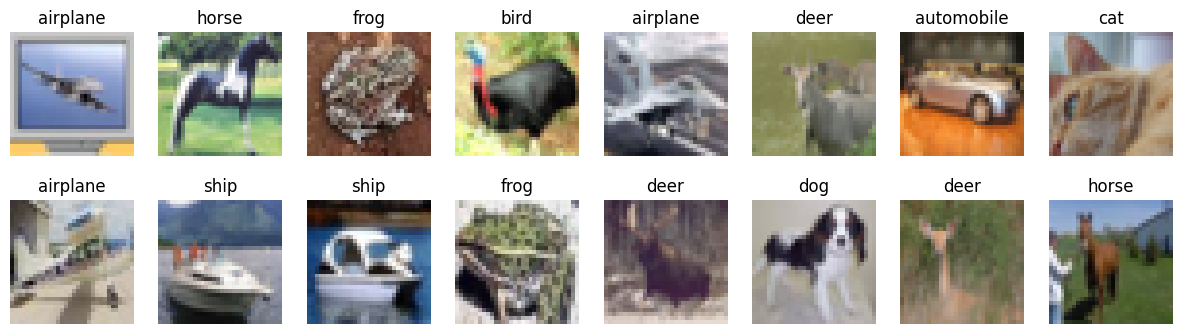

In [ ]:
# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Prepare data

## Xét class label có dạng one-hot

In [ ]:
# normalize inputs
x_train2 = (x_train / 255) - 0.5
x_test2 = (x_test / 255) - 0.5
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Define CNN architecture

In [ ]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers import LeakyReLU

In [ ]:
def make_model():
    """
    Returns `Sequential` model.
    """
    model = Sequential()
    model.add(Conv2D(16, (3, 3), input_shape=(32, 32, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    
    return model

In [ ]:
# describe model
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                        

# Train model

In [ ]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10

model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adam(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Training takes approximately **1.5 hours**. You're aiming for ~0.80 validation accuracy.

In [ ]:
# we will save model checkpoints to continue training in case of kernel death
model_filename = 'cifar.{0:03d}.hdf5'
last_finished_epoch = None

# Evaluate model with one-hot - CE

In [ ]:
# fit model
import tensorflow_addons as tfa
model.fit(
    x_train2, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory(), 
               tfa.callbacks.TQDMProgressBar(),
               keras.callbacks.ModelCheckpoint(model_filename)],
    validation_data=(x_test2, y_test2),
    shuffle=True,
    verbose=0,
    initial_epoch=last_finished_epoch or 9
)

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Learning rate: 0.0019371024
Epoch 10/10


0/1563           ETA: ?s - 

IndexError: ignored

-Độ chính xác khi đánh giá với MSE và class label là int (0-9). 

 + loss: 1.3396 - accuracy: 0.5204 
 + val_loss: 0.9539 - val_accuracy: 0.6690

# Evaluate model with int - MSE

In [ ]:
# fit model
import tensorflow_addons as tfa

model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss=keras.losses.MeanSquaredError(),  # we train 10-way classification
    optimizer=keras.optimizers.Adam(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory(), 
               tfa.callbacks.TQDMProgressBar(),
               keras.callbacks.ModelCheckpoint(model_filename)],
    validation_data=(x_test, y_test),
    shuffle=True,
    verbose=0,
    initial_epoch=last_finished_epoch or 9
)

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Learning rate: 0.0019371024
Epoch 10/10


0/1563           ETA: ?s - 

IndexError: ignored

-Độ chính xác khi đánh giá với MSE và class label là int (0-9). 

+ loss: 27.7000 - accuracy: 0.0999

+ val_loss: 27.7000 - val_accuracy: 0.1000